In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

a)

Using the PDE of the Geometric Brownian Motion and simulate for 1000 paths, each path has 5 * 252 = 1260 (days) time steps.

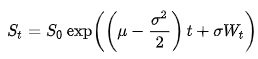

In [2]:
#parameters
n_sims = 1000
drift = 0
time = 5*252
vol = 9.3/100
S0 = 1.37625

In [3]:
#Weiner process with 1260 time steps
r = np.random.normal(0,1,252*5)
r

array([ 0.11433659,  0.43384495,  0.62821072, ..., -1.40739712,
       -0.93143368, -0.3256793 ])

In [4]:
#Store all the paths
paths = [None]*1000
for i in range(0,1000):
    paths[i] = S0*np.exp((drift-vol**2*0.5) + vol*np.random.normal(0,1,252*5))


<function matplotlib.pyplot.show(*args, **kw)>

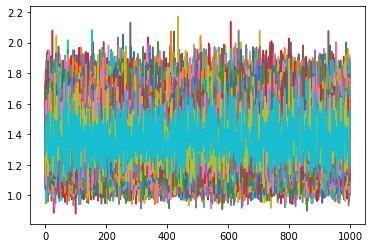

In [5]:
plt.plot(paths)
plt.show

In [6]:
paths[0]

array([1.26792036, 1.18039315, 1.38806973, ..., 1.36967118, 1.13734557,
       1.26653169])

In [7]:
#import the excel data
df = pd.read_excel (r'C:\Users\Kit\Downloads\validus.xlsx')
print (df)

        Date       Fund Cashflow Type  \
0 2021-08-31  Validus V        Equity   
1 2022-08-31  Validus V      Proceeds   
2 2023-08-31  Validus V      Proceeds   
3 2024-08-31  Validus V      Proceeds   
4 2025-08-31  Validus V      Proceeds   
5 2026-08-31  Validus V      Proceeds   

   Cashflow Amount (in Local Asset Currecny) Local Asset Currency  \
0                                 -100000000                  GBP   
1                                   15000000                  GBP   
2                                   15000000                  GBP   
3                                   15000000                  GBP   
4                                   15000000                  GBP   
5                                  115000000                  GBP   

  Fund Currency  Base Case IRR  
0           USD       0.149914  
1           USD            NaN  
2           USD            NaN  
3           USD            NaN  
4           USD            NaN  
5           USD            NaN

In [8]:
#set all initial rate to the spot rate at 1.37625
rates= []
for i in range(0,1000):
    rates.append([1.37625])
#append the rates in time 1,2,3,4,5
for i in range(0,1000):
    for j in range(251,1260,252):
        rates[i].append(paths[i][j])

In [40]:
#So the rates of each path are according to each time step
rates[0]

[1.37625,
 1.4429148875556947,
 1.4546791052468298,
 1.5309661675313713,
 1.3203744789428957,
 1.2665316906817832]

In [10]:
#convert the cashflow into USD
converted = df['Cashflow Amount (in Local Asset Currecny)'].values*rates

In [11]:
#Calculate the IRR and store them
irr = []
for i in range(0,1000):
    irr.append(np.irr(converted[i]))

In [12]:
#The 95%, 50%, and 5% percentile of the IRR
percentile_95 = np.percentile(irr,95)
percentile_50 = np.percentile(irr,50)
percentile_5 = np.percentile(irr,5)
print('The 95% percetile is', round(percentile_95*100,2),'%')
print('The 50% percetile is', round(percentile_50*100,2),'%')
print('The 5% percetile is', round(percentile_5*100,2),'%')


The 95% percetile is 17.69 %
The 50% percetile is 14.8 %
The 5% percetile is 12.44 %


<function matplotlib.pyplot.show(*args, **kw)>

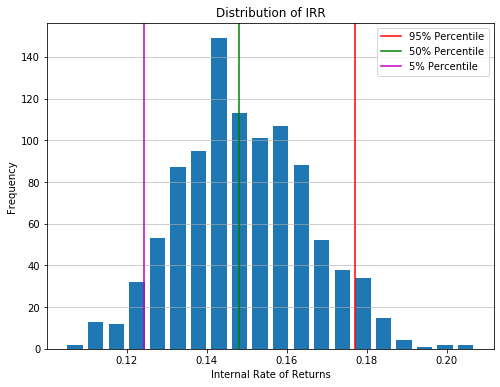

In [13]:
#IRR distribution plot with percentiles
plt.figure(figsize=(8, 6))
plt.hist(irr,bins=20,rwidth=0.75)
plt.xlabel('Internal Rate of Returns')
plt.ylabel('Frequency')
plt.title('Distribution of IRR')
plt.grid(axis='y',alpha=0.75)
plt.axvline(percentile_95,label='95% Percentile',color='r')
plt.axvline(percentile_50,label='50% Percentile',color='g')
plt.axvline(percentile_5,label='5% Percentile',color='m')
plt.legend()
plt.show

In [14]:
#Parameters for option
notional=100000000
K=1.37625
rd=0
rf=0
t=5

In [15]:
#Black-scholes put option for FX
def BS_put(S,K,v,t,rd,rf):
    d1 = ((rd-rf+v**2*0.5)*t+np.log(S/K))/(v*np.sqrt(t))
    d2 = ((rd-rf-v**2*0.5)*t+np.log(S/K))/(v*np.sqrt(t))
    put = K*np.exp(-rd*t)*norm.cdf(-d2)-S*np.exp(-rf*t)*norm.cdf(-d1)
    return put

In [16]:
#put price per unit
put_price=BS_put(S0,S0,vol,5,0,0)
put_price

0.11397073996495588

In [41]:
#Take all the simulated FX rate at expiry date
rates_at_time_5 = []
for i in range(0,1000):
    rates_at_time_5.append(rates[i][-1])
rates_at_time_5[0]

1.2665316906817832

In [42]:
#the simulation is already ran, so just compare the strike to the final rate
#The option price will be the maximum of strike - final rate or 0,
#and discounted back to the trade date
mc_put_price = [np.maximum(K-x,0)*np.exp(-(rd-rf)*t) for x in rates_at_time_5]
mc_put_price[0:10]

[0.1097183093182168,
 0.0,
 0.09190199916638475,
 0.0,
 0.0,
 0.0,
 0.03915703320207675,
 0.0,
 0.0,
 0.08068497521107099]

In [19]:
#Taking the average of all the option price
#this is the option premium per unit
mc_put_average = np.sum(mc_put_price)/1000
mc_put_average

0.051657766052441025

In [20]:
#Option premium using the simulated FX rates on trade date
mc_put_average*notional

5165776.605244103

In [21]:
average_final_rate=0
for i in range(0,1000):
    average_final_rate += rates[i][-1]
average_final_rate=average_final_rate/1000
average_final_rate

1.372862876936959

In [22]:
#option payoff
notional*(K-average_final_rate)

338712.3063040898

In [23]:
#preimum - payoff
option_premium = mc_put_average*notional-notional*(K-average_final_rate)
option_premium

4827064.298940013

In [33]:
rates_with_option= []
for i in range(0,1000):
    rates_with_option.append([1.37625])
#append the rates in time 1,2,3,4,5
for i in range(0,1000):
    for j in range(251,1260,252):
        rates_with_option[i].append(paths[i][j])
    if rates_with_option[i][-1] < 1.37625:
        rates_with_option[i][-1] = 1.37625

In [43]:
rates_with_option[0]

[1.37625,
 1.4429148875556947,
 1.4546791052468298,
 1.5309661675313713,
 1.3203744789428957,
 1.37625]

In [26]:
df['Cashflow Amount (in Local Asset Currecny)'][0]=df['Cashflow Amount (in Local Asset Currecny)'][0]-option_premium

C:\Users\Kit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
df['Cashflow Amount (in Local Asset Currecny)']

0   -104827064
1     15000000
2     15000000
3     15000000
4     15000000
5    115000000
Name: Cashflow Amount (in Local Asset Currecny), dtype: int64

In [36]:
#convert the cashflow into USD with option
converted_with_option = df['Cashflow Amount (in Local Asset Currecny)'].values*rates_with_option
converted_with_option

array([[-1.44268247e+08,  2.16437233e+07,  2.18201866e+07,
         2.29644925e+07,  1.98056172e+07,  1.58268750e+08],
       [-1.44268247e+08,  2.13541805e+07,  1.95015166e+07,
         1.93114305e+07,  1.92282843e+07,  1.70620828e+08],
       [-1.44268247e+08,  1.90195506e+07,  1.86030542e+07,
         1.84603877e+07,  2.13870917e+07,  1.58268750e+08],
       ...,
       [-1.44268247e+08,  2.15294908e+07,  2.26008628e+07,
         2.14062384e+07,  2.18828151e+07,  1.58268750e+08],
       [-1.44268247e+08,  2.25867996e+07,  1.81919346e+07,
         2.64256785e+07,  1.80701281e+07,  1.79097556e+08],
       [-1.44268247e+08,  2.11620380e+07,  2.17079476e+07,
         1.95200357e+07,  1.93620418e+07,  1.61396388e+08]])

In [37]:
#Calculate the IRR and store them
irr_with_option = []
for i in range(0,1000):
    irr_with_option.append(np.irr(converted_with_option[i]))

In [38]:
#The 95%, 50%, and 5% percentile of the IRR
percentile_95_with_option = np.percentile(irr_with_option,95)
percentile_50_with_option = np.percentile(irr_with_option,50)
percentile_5_with_option = np.percentile(irr_with_option,5)
print('The 95% percetile with option is', round(percentile_95_with_option*100,2),'%')
print('The 50% percetile with option is', round(percentile_50_with_option*100,2),'%')
print('The 5% percetile with option is', round(percentile_5_with_option*100,2),'%')


The 95% percetile with option is 16.29 %
The 50% percetile with option is 14.0 %
The 5% percetile with option is 12.9 %


<function matplotlib.pyplot.show(*args, **kw)>

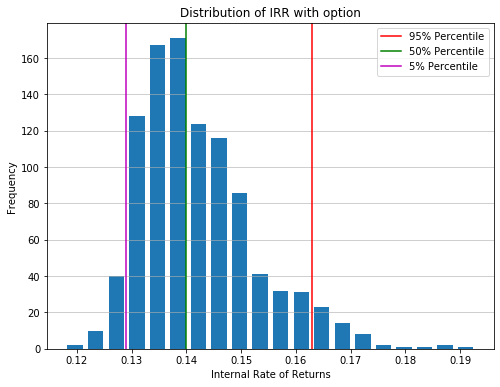

In [39]:
#IRR distribution plot with percentiles
plt.figure(figsize=(8, 6))
plt.hist(irr_with_option,bins=20,rwidth=0.75)
plt.xlabel('Internal Rate of Returns')
plt.ylabel('Frequency')
plt.title('Distribution of IRR with option')
plt.grid(axis='y',alpha=0.75)
plt.axvline(percentile_95_with_option,label='95% Percentile',color='r')
plt.axvline(percentile_50_with_option,label='50% Percentile',color='g')
plt.axvline(percentile_5_with_option,label='5% Percentile',color='m')
plt.legend()
plt.show

d)

The impact of the put option skewed the distribution of the IRR to the right , as it significantly reduced the portfolio FX risk exposure due to a lower bound is set at the strike FX rate. However the initial outlay is thus increased by 4.83 million GBP. 

The 95% percentile reduced from 17.69% to 16.29% and the 50% percetile went from 14.8% to 14%. The changes of the percentiles are relatively small given that we are able to hedge a notional value of 100 million.

The option is able to give certainty on the final cashflow for at least 100M and therefore would be helpful in ensuring the cashflow and aid other projects' planning and forecasting.
